In [503]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import wordcloud as wc
import string
import tensorflow as tf
from tensorflow import keras
import keras.preprocessing as ppr
from keras.utils.data_utils import pad_sequences
import nltk
from nltk.corpus import stopwords
import ssl
from sklearn import metrics
import seaborn as sns

# Data Exploration

In [504]:
df = pd.read_csv('stock_data (1).csv')

In [505]:
df.head(10)

Text  Sentiment
0  Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1
1  user: AAP MOVIE. 55% return for the FEA/GEED i...          1
2  user I'd be afraid to short AMZN - they are lo...          1
3                                  MNTA Over 12.00            1
4                                   OI  Over 21.37            1
5                                  PGNX  Over 3.04            1
6  AAP - user if so then the current downtrend wi...         -1
7  Monday's relative weakness. NYX WIN TIE TAP IC...         -1
8  GOOG - ower trend line channel test & volume s...          1
9             AAP will watch tomorrow for ONG entry.          1

In [506]:
# Check for null values
df.isnull().values.any()

False

In [507]:
# Get count for number of sentiments in the dataset
df1 = df.groupby('Sentiment').count()

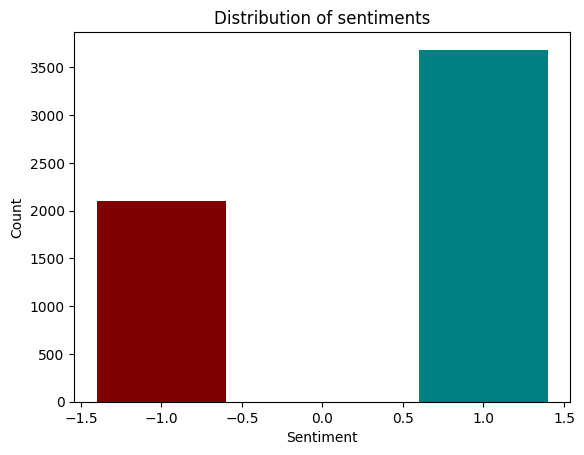

In [508]:
# Distribution of sentiments - almost 2 times as much positive as negative sentiments
plt.bar(df1.index, df1['Text'], color = ['maroon', 'teal'])
plt.title('Distribution of sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

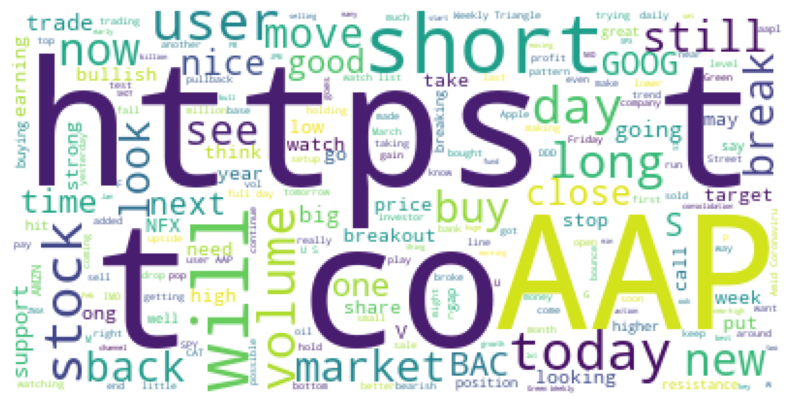

In [509]:
# View some of the words within our dataset
stopwords1 = set(wc.STOPWORDS)
cloud = wc.WordCloud(stopwords = stopwords1, background_color = 'white')
cloud = cloud.generate("".join(sentence for sentence in df['Text']))

# Plot wordcloud
plt.figure(figsize = (10,8))
plt.imshow(cloud)
plt.axis('off')
plt.show()

From the wordcloud, it would seem that https is a very common term appearing in the dataset, links were kept within the data, we would have to remove them.

# Data Preparation

In [510]:
df['Sentiment'][7]

-1

In [511]:
# Convert -1 -> 0, representing negative sentiment
df['Sentiment'].mask(df['Sentiment'] == -1, 0, inplace = True)

In [512]:
# View results
df['Sentiment'][7]

0

In [513]:
# Links in between text, as discovered within the wordcloud
df['Text'][5000]

"RT @bysarahkrouse: Story on Verizon's purchase of conferencing platform BlueJeans here: https://t.co/CfZo9K1Zoa"

In [514]:
# Shorthand symbols are used which may cause problems for the model to interpret.
df['Text'][100]

'BAC In  12.00 since there is consolidation  this level. We could close = > 12.09 if market is stable in pm IMHO.'

In [515]:
# Clean up dataset by removing links
df['Text'] = df['Text'].str.replace(r'\s*https?://\S+(\s+|$)', ' ').str.strip()
    
# Replace '>' and '>=' symbols with 'above', '<' and '<=' symbols with below
to_replace = {'= >':'above', '=>': 'above', '>': 'above',
             '= <':'below', '=<': 'below', '<': 'below'}

for char in to_replace:
    df['Text'] = df['Text'].str.replace(char, to_replace[char])

/var/folders/73/hzzs4r7n0gb413l7n6njcmnh0000gn/T/ipykernel_1524/3257462056.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Text'] = df['Text'].str.replace(r'\s*https?://\S+(\s+|$)', ' ').str.strip()


In [516]:
# Checking results
# Equality signs converted to text
df['Text'][100]

'BAC In  12.00 since there is consolidation  this level. We could close above 12.09 if market is stable in pm IMHO.'

In [517]:
# Links removed
df['Text'][5000]

"RT @bysarahkrouse: Story on Verizon's purchase of conferencing platform BlueJeans here:"

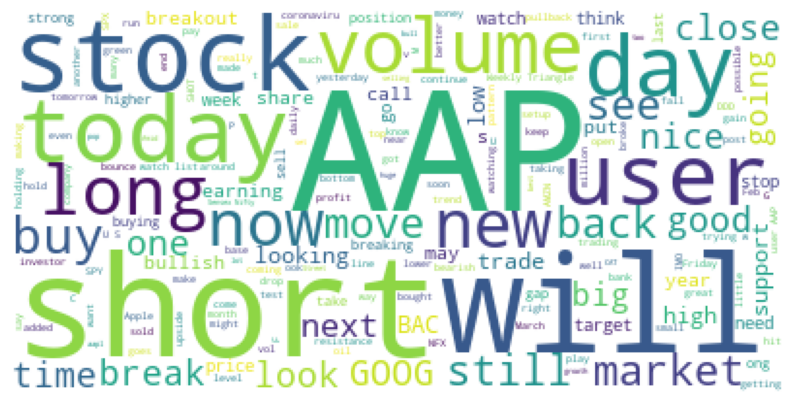

In [518]:
cloud2 = wc.WordCloud(stopwords = stopwords1, background_color = 'white')
cloud2 = cloud2.generate("".join(sentence for sentence in df['Text']))

# Plot wordcloud
plt.figure(figsize = (10,8))
plt.imshow(cloud2)
plt.axis('off')
plt.show()

We can also view to new wordcloud, 'https' has been removed and the new words look to be more relevant.

In [519]:
# Removing punctuations within the data
for i in string.punctuation:
    df['Text'] = df['Text'].str.replace(i , '').str.strip()

/var/folders/73/hzzs4r7n0gb413l7n6njcmnh0000gn/T/ipykernel_1524/1327366722.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Text'] = df['Text'].str.replace(i , '').str.strip()


In [520]:
# View results
df['Text'][5000]

'RT bysarahkrouse Story on Verizons purchase of conferencing platform BlueJeans here'

In [521]:
# Download additional content from NLTK, had an error with SSL, hence copied this try/except from stackoverflow for it to work.
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yeoshuheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yeoshuheng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yeoshuheng/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yeoshuheng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [522]:
# Bring in stopwords from NLTK
sw = set(stopwords.words('english'))

# Add custom stopwords - in this case RT
custom = ['rt']

# Remove words from the data + forces everything to be a lowercase string.
df['Text'] = df['Text'].map(lambda x: " ".join([str(word).lower() for word in x.split() if word.lower() not in sw and word.lower() not in custom]))

In [523]:
# View results
df['Text'][5000]

'bysarahkrouse story verizons purchase conferencing platform bluejeans'

In [524]:
# Add all the processing we did into a single function just in case
def clean_data(df):
    """
    Takes in a pandas data frame and cleans the text column such that it is ready for the model.
    """
    
    # Remove urls
    df['Text'] = df['Text'].str.replace(r'\s*https?://\S+(\s+|$)', ' ').str.strip()
    
    # Replace inequalites
    to_replace = {'= >':'above', '=>': 'above', '>': 'above',
             '= <':'below', '=<': 'below', '<': 'below'}

    for char in to_replace:
        df['Text'] = df['Text'].str.replace(char, to_replace[char])
        
    # Remove punctuations
    for i in string.punctuation:
        df['Text'] = df['Text'].str.replace(i , '').str.strip()
        
    # Remove stopwords
    df['Text'] = df['Text'].map(lambda x: " ".join([str(word).lower() for word in x.split() if word.lower() not in sw and word.lower() not in custom]))
    
    return df

In [525]:
# Create x & y variables sets
x = df['Text']
y = df['Sentiment']

# Create train test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8)

In [526]:
# View results - split successful
print(f'Training: X: {len(x_train)}, Y: {len(y_train)}')
print(f'Testing: X: {len(x_test)}, Y: {len(y_test)}')

Training: X: 4632, Y: 4632
Testing: X: 1159, Y: 1159


In [527]:
y_train

4496    1
4098    1
2235    1
3140    1
3309    0
       ..
2706    1
647     1
868     1
3971    1
237     1
Name: Sentiment, Length: 4632, dtype: int64

In [528]:
x_train

4496                         aap time invest apple shares
4098                                             qco went
2235                                         tek long 165
3140    aap interesting ppl blame co heggies darkpools...
3309    aap capitalizing bigger picture moves higher t...
                              ...                        
2706    msft closed 200emashortterm uptrend intact sig...
647     imm didnt come xmas bb10 take next xmas take s...
868     thought call early screamed fashion makeover w...
3971    taking profits cmg 321 time hero weekend thing...
237              jds beautiful trend 135 bring dip buyers
Name: Text, Length: 4632, dtype: object

In [529]:
# Keep a copy for final evaluation
y_final = x_test

In [530]:
# Tokenize the training sets
max_vocab = 10000
tokenizer = ppr.text.Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(x_train)

# Get word index
widx = tokenizer.word_index

# View number of vocabulary in word index
len(widx)

9647

In [531]:
# Create sequences
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# View results - size is correct
print(f'Training set: {len(x_train)}')
print(f'Testing set: {len(x_test)}')

Training set: 4632
Testing set: 1159


In [532]:
x_train[2]

[1158, 8, 2644]

In [533]:
x_train[12]

[58, 4044, 2030]

In [534]:
# As each text are of different sizes - we need to pad the sequences to make them the same.
x_train = pad_sequences(x_train)

# Force max length of y_train sequences to match that of the max length of x train sequences
x_test = pad_sequences(x_test, maxlen = x_train.shape[1])

# View results - sequences are of the same length
print(f'Training set X: {x_train.shape}')
print(f'Testing set X: {x_test.shape}')

Training set X: (4632, 23)
Testing set X: (1159, 23)


# Model evaluation

In [590]:
# Define some parameters
EPOCHS = 10

In [601]:
# Build model
model = keras.Sequential([
    
    # Add embedding layer
    keras.layers.Embedding(max_vocab, 32, input_length = x_train.shape[1]),
    
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(64, activation = 'relu', return_sequences = True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, activation = 'relu'),
    
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(32, activation = 'relu'),
    
    # Final output should only be between 0 or 1, hence sigmoid
    keras.layers.Dense(1, activation = 'sigmoid')
])

# Compile model, since output is 1 or 0, binary crossentropy used instead
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy')

model.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, 23, 32)            320000    
                                                                 
 dropout_9 (Dropout)         (None, 23, 32)            0         
                                                                 
 lstm_60 (LSTM)              (None, 23, 64)            24832     
                                                                 
 dropout_10 (Dropout)        (None, 23, 64)            0         
                                                                 
 lstm_61 (LSTM)              (None, 128)               98816     
                                                                 
 dense_136 (Dense)           (None, 128)               16512     
                                                                 
 dense_137 (Dense)           (None, 32)              

In [602]:
# Train model
model.fit(x_train, y_train, epochs = EPOCHS)

Epoch 1/10
145/145 [==============================] - 5s 26ms/step - loss: 0.6546
Epoch 2/10
145/145 [==============================] - 4s 27ms/step - loss: 0.4256
Epoch 3/10
145/145 [==============================] - 4s 27ms/step - loss: 0.2086
Epoch 4/10
145/145 [==============================] - 4s 27ms/step - loss: 0.1036
Epoch 5/10
145/145 [==============================] - 4s 26ms/step - loss: 0.0633
Epoch 6/10
145/145 [==============================] - 4s 27ms/step - loss: 0.0424
Epoch 7/10
145/145 [==============================] - 4s 27ms/step - loss: 0.0295
Epoch 8/10
145/145 [==============================] - 4s 27ms/step - loss: 0.0199
Epoch 9/10
145/145 [==============================] - 4s 27ms/step - loss: 0.0200
Epoch 10/10
145/145 [==============================] - 4s 27ms/step - loss: 0.0128


# Model Evaluation

In [603]:
def filter_pred(predictions):
    """
    Takes in a series of predictions and converts them to binary values.
    """
    predictions = list(map(lambda x: 1 if (x[0] >= 0.5) else 0, predictions))
    
    return predictions

In [604]:
def generate_eval(cm):
    """
    Takes in a confusion matrix and returns key values as a single string.
    """
    
    # Get true/false negatives/postitives
    t_neg = cm[0][0]
    f_neg = cm[0][1]
    t_pos = cm[1][1]
    f_pos = cm[0][1]
    
    # Calculate accuracy - correct classification
    acc = (t_pos + t_neg)/(t_neg + t_pos + f_pos + f_neg) 
    
    # Calculate specificity - no of predicted 0 out of actual 0s.
    spec = t_neg/(f_pos + t_neg)
    
    # Calculate precision - correct predictions of 1 out of predictions of 1s.
    pre = t_pos/(t_pos + f_pos)
    
    # Calculate sensitivity - no. of predicted 1 out of actual 1s.
    sens = t_pos/(t_pos + f_neg)
    
    # Calculate F1-Score, balance index between precision and sensitivity.
    f1 = (2 * pre * sens)/(pre + sens)
    
    # Return string
    return f'TP: {t_pos}, TN: {t_neg}, FP: {f_pos}, FN: {f_neg}, Accuracy: {round(acc,2)}, Specificity: {round(spec,2)}, F-1 Score: {round(f1,2)} '
    

In [605]:
# Generate predictions
y_pred = model.predict(x_test)

37/37 [==============================] - 0s 7ms/step


In [606]:
# Convert values to 0 and 1s
y_pred = filter_pred(y_pred)
y_pred[:10]

[1, 0, 1, 1, 0, 1, 0, 0, 1, 1]

In [607]:
# Add back to our previously saved dataframe
final_df = pd.DataFrame(y_final)
final_df['Predicted Sentiment'] = y_pred
final_df['Actual Sentiment'] = y_test

In [608]:
# View results
final_df.head()

Text  Predicted Sentiment  \
5061  saudi crown prince mohammed bin salmanâ€™s pub...                    1   
941   aj really strong caution overbought si declini...                    0   
4111  mdx nice setup multiple timeframes needs bette...                    1   
4504  v angebound consol pattern volume coming top c...                    1   
3603  seen outperform peers week nf ceg pcyc n mwiv ...                    0   

      Actual Sentiment  
5061                 1  
941                  1  
4111                 1  
4504                 1  
3603                 1

In [609]:
# Generate Confusion matrix
cm = metrics.confusion_matrix(final_df['Actual Sentiment'], final_df['Predicted Sentiment'])

# Generate key values
ev = generate_eval(cm)
print(ev)

TP: 572, TN: 295, FP: 117, FN: 117, Accuracy: 0.79, Specificity: 0.72, F-1 Score: 0.83 


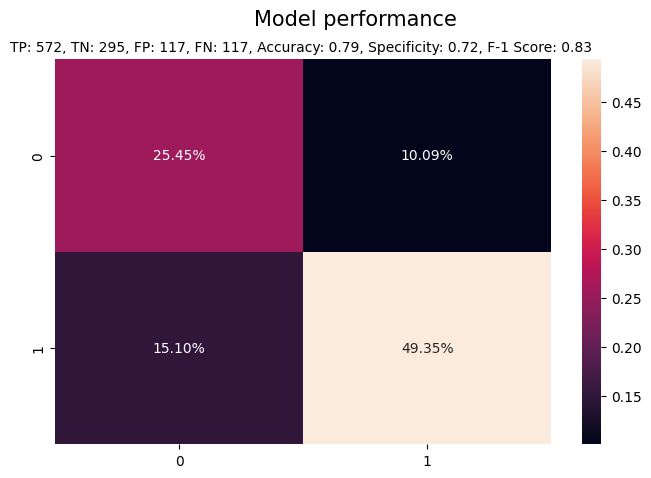

In [610]:
# Plot confusion matrix
plt.figure(figsize = (8, 5))
plt.suptitle('Model performance', ha = 'center', fontsize = 15)
plt.title(ev, fontsize = 10)
fin = sns.heatmap(cm/np.sum(cm), annot = True, fmt = '.2%')
plt.show()

# Save image
pic = fin.get_figure()
pic.savefig('Performance.png')